In [1]:
import numpy as np
import torch
import tensorflow
import os
import json
import time
import glob
import re
import sys
import collections
from nltk import flatten
import dask
from dask import delayed,compute
import dask.dataframe as dd
from dask.multiprocessing import get
from tqdm._tqdm_notebook import tqdm_notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm_notebook.pandas()

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

import warnings
warnings.filterwarnings('ignore')

C:\Users\pchaudhari\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  app.launch_new_instance()


In [2]:
#Read tran text data
train_text = pd.read_csv('train_text.csv',index_col=0)
train_text.tail(20)

,Text,FileName,Folder
320925,"Pivotal Web Server, Support, Training & Techni...",https---www.vmware.com-support-vfabric-web-ser...,2021-input-vmw-com
320926,"Pivotal Web Server, Support, Training & Techni...",https---www.vmware.com-support-vi3.txt,2021-input-vmw-com
320927,"vSAN Support, Training & Technical Documentati...",https---www.vmware.com-support-virtual-san.txt,2021-input-vmw-com
320928,VMware VM Importer Utility 2.0\nSupport\nEnd U...,https---www.vmware.com-support-vmimporter_v2.txt,2021-input-vmw-com
320929,vRealize Business for Cloud and vRealize Busin...,https---www.vmware.com-support-vrealize-busine...,2021-input-vmw-com
320930,vRealize Code Stream Support Center - VMware\n...,https---www.vmware.com-support-vrealize-code-s...,2021-input-vmw-com
320931,"vRealize Log Insight, Support, Training & Tech...",https---www.vmware.com-support-vrealize-log-in...,2021-input-vmw-com
320932,Vrealize Operations For Horizon\nSupport\nVrea...,https---www.vmware.com-support-vrealize-operat...,2021-input-vmw-com
320933,vRealize Operations Manager 6.0 - Vmware\nSupp...,https---www.vmware.com-support-vrealize-operat...,2021-input-vmw-com
320934,"vRealize Operations Support, Training & Techni...",https---www.vmware.com-support-vrealize-operat...,2021-input-vmw-com


In [3]:
train_text.isnull().sum()

Text        260
FileName      0
Folder        0
dtype: int64

In [4]:
train_text_cleaned = train_text.loc[train_text[~train_text['Text'].isnull()].index.tolist()]
train_text_cleaned.isnull().sum()

Text        0
FileName    0
Folder      0
dtype: int64

In [5]:
train_text_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320685 entries, 0 to 320944
Data columns (total 3 columns):
Text        320685 non-null object
FileName    320685 non-null object
Folder      320685 non-null object
dtypes: object(3)
memory usage: 9.8+ MB


In [6]:
#Install scispcy and spacy and pretrained model en_core_web_sm for analysis
!pip install spacy
!pip install scispacy
!python -m spacy download en_core_web_sm

You should consider upgrading via the 'c:\users\pchaudhari\appdata\local\continuum\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\pchaudhari\appdata\local\continuum\anaconda3\python.exe -m pip install --upgrade pip' command.


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


You should consider upgrading via the 'C:\Users\pchaudhari\AppData\Local\Continuum\anaconda3\python.exe -m pip install --upgrade pip' command.


In [7]:
import scispacy
import spacy
import en_core_web_sm

In [8]:
## loading en_core_sci_lg model and disabling parser and ner, as these are not going to be used in EDA, disabling these functions from NLP pipeline can sometimes make a big difference and improve loading speed
nlp = en_core_web_sm.load(disable=["parser", "ner"])
nlp.max_length = 2000000

In [140]:
# Function for cleaning data by using POS tagging and Lemmatization
def clean_text(sentence):
    tokens = [word.lemma_ for word in nlp(str(sentence)) 
                  if not (word.like_num 
                          or word.is_stop
                          or word.is_punct
                          or word.is_space
                          or word.like_url
                          or word.like_email
                          or word.is_currency
                          or word.pos_ =='VBZ' 
                          or word.pos_ =='ADP'
                          or word.pos_ =='PRON'
                          or word.pos_ =='AUX'

                         )] 
    
    return tokens

In [10]:
train_text__ = train_text_cleaned[~train_text_cleaned["Text"].duplicated()]
train_text__.tail(10)

,Text,FileName,Folder
320935,Vrealize Orchestrator\nSupport\nVrealize Orche...,https---www.vmware.com-support-vrealize-orches...,2021-input-vmw-com
320936,"vRealize Suite Support, Training & Technical D...",https---www.vmware.com-support-vrealize-suite.txt,2021-input-vmw-com
320937,"vSphere Data Protection Advanced Support, Trai...",https---www.vmware.com-support-vsphere-data-pr...,2021-input-vmw-com
320938,VMware vSphere Hypervisor ESXi Support Center\...,https---www.vmware.com-support-vsphere-hypervi...,2021-input-vmw-com
320939,vSphere Storage Appliance Support Center - VMw...,https---www.vmware.com-support-vsphere-storage...,2021-input-vmw-com
320940,vSphere Web Client Videos\nSupport\nvSphere Su...,https---www.vmware.com-support-vsphere-vsphere...,2021-input-vmw-com
320941,"vSphere, Training & Technical Documentation\nS...",https---www.vmware.com-support-vsphere.txt,2021-input-vmw-com
320942,Open Source Files for vSphere RC1\nSupport\nvS...,https---www.vmware.com-support-vsphere_rc1_os.txt,2021-input-vmw-com
320943,Customer Support Welcome Center\nSupport\nWelc...,https---www.vmware.com-support-welcome-center.txt,2021-input-vmw-com
320944,"VMware Workstation Support, Training & amp; Te...",https---www.vmware.com-support-workstation.txt,2021-input-vmw-com


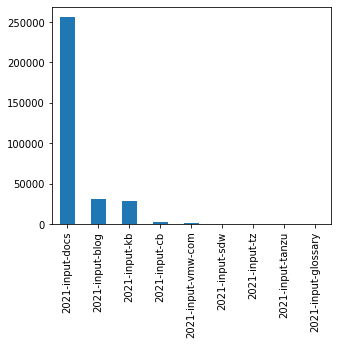

In [11]:
plt.figure(figsize=(5,4))
train_text_cleaned['Folder'].value_counts().plot.bar()
plt.show()

In [12]:
train_text__["Text"] = train_text__["Text"].apply(lambda x:clean_text(x))

In [76]:
train_text__.head()

,Text,FileName,Folder,Text_
0,"[homepage, VMware, blog, VMware, blog, Feature...",https---blogs.vmware.com-.txt,2021-input-blog,"[homepage, VMware, blog, VMware, blog, Feature..."
1,"[Affiliate, Sources, VMware, Blogs, Affiliate,...",https---blogs.vmware.com-affiliate-sources.txt,2021-input-blog,"[Affiliate, Sources, VMware, Blogs, Affiliate,..."
2,"[hour, PASS, Session, Slides, Uploaded, VMware...",https---blogs.vmware.com-affiliates-24-hours-o...,2021-input-blog,"[hour, PASS, Session, Slides, Uploaded, VMware..."
3,"[novos, lab, disponiveis, VMware, Hands, Labs,...",https---blogs.vmware.com-affiliates-41-novos-l...,2021-input-blog,"[novos, lab, disponiveis, VMware, Hands, Labs,..."
4,"[hol, Dave, Rollins, vExpert, Pro, w, Valdecir...",https---blogs.vmware.com-affiliates-433-hol-w-...,2021-input-blog,"[hol, Dave, Rollins, vExpert, Pro, w, Valdecir..."


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text xticklabel objects>)

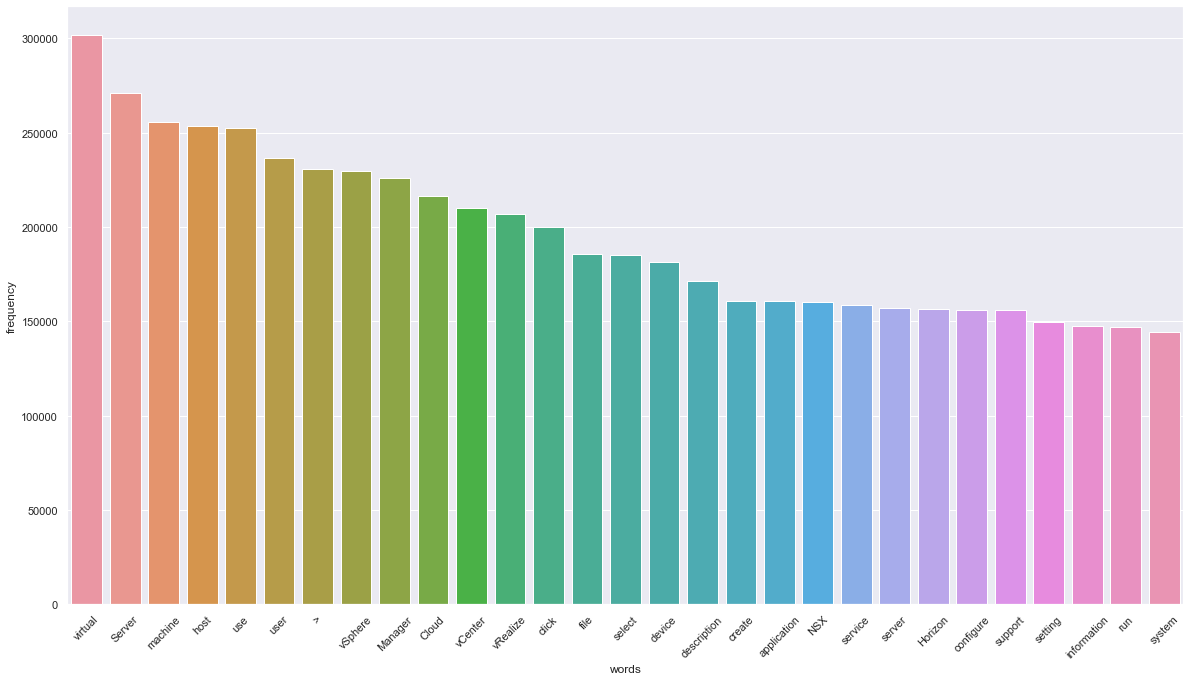

In [14]:
tokens_df= train_text__["Text"].dropna() #drop null values
# Get top 30 tokens based upon frequency in whole corpus
word_freq_top30 = pd.DataFrame(collections.Counter(flatten(tokens_df.to_list())).most_common(30),columns=['words',"frequency"])

##Plot bar graph of words wrt frequency 
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(20,11)})
ax = sns.barplot(x=word_freq_top30['words'][1:], y=word_freq_top30['frequency'])
plt.xticks(rotation=45)

In [15]:
train_text__.to_csv("train_text_token.csv")

In [16]:
train_text__.head()

,Text,FileName,Folder
0,"[homepage, VMware, blog, VMware, blog, Feature...",https---blogs.vmware.com-.txt,2021-input-blog
1,"[Affiliate, Sources, VMware, Blogs, Affiliate,...",https---blogs.vmware.com-affiliate-sources.txt,2021-input-blog
2,"[hour, PASS, Session, Slides, Uploaded, VMware...",https---blogs.vmware.com-affiliates-24-hours-o...,2021-input-blog
3,"[novos, lab, disponiveis, VMware, Hands, Labs,...",https---blogs.vmware.com-affiliates-41-novos-l...,2021-input-blog
4,"[hol, Dave, Rollins, vExpert, Pro, w, Valdecir...",https---blogs.vmware.com-affiliates-433-hol-w-...,2021-input-blog


In [19]:
train_text__["Text"][0]

['homepage',
 'VMware',
 'blog',
 'VMware',
 'blog',
 'Featured',
 'Articles',
 'Company',
 'Ws',
 'H',
 'vmworld',
 'Proposals',
 'detail',
 'need',
 'submit',
 'proposal',
 'year',
 'vmworld',
 'application',
 'open',
 'April',
 'Maryam',
 'Scoble',
 'Company',
 'Cloud',
 'Security',
 'Digital',
 'Workspace',
 'Modern',
 'Apps',
 'Categories',
 'Company',
 'Cloud',
 'Security',
 'Digital',
 'Workspace',
 'Modern',
 'Apps',
 'Search',
 'Submit',
 'Search',
 'International',
 'GfK',
 'leader',
 'mondial',
 'dan',
 'le',
 'domaine',
 'des',
 'donnee',
 'et',
 'de',
 "l'analytique",
 'se',
 'tourne',
 'ver',
 'le',
 'cloud',
 'hybride',
 'VMware',
 'pour',
 'accroitre',
 'son',
 'offre',
 'de',
 'valeur',
 'VMware',
 'France',
 'International',
 'Wang',
 'Lu',
 'Xu',
 'Ni',
 'Hua',
 'NSX',
 'Ji',
 'Shu',
 'Wen',
 'Zhang',
 'Xi',
 'Lie',
 'Er',
 'Bai',
 'Ling',
 'Jiu',
 'NSX',
 'VZhuan',
 'TShi',
 'Qian',
 'Gui',
 'Hua',
 'Ji',
 'Gong',
 'Ju',
 'Tao',
 'Lun',
 'Liu',
 'VMware',
 'Taiwan',

In [51]:
new = pd.read_csv("train_text_token.csv",index_col=0)

In [84]:
new.head()

,Text,FileName,Folder
0,"['homepage', 'VMware', 'blog', 'VMware', 'blog...",https---blogs.vmware.com-.txt,2021-input-blog
1,"['Affiliate', 'Sources', 'VMware', 'Blogs', 'A...",https---blogs.vmware.com-affiliate-sources.txt,2021-input-blog
2,"['hour', 'PASS', 'Session', 'Slides', 'Uploade...",https---blogs.vmware.com-affiliates-24-hours-o...,2021-input-blog
3,"['novos', 'lab', 'disponiveis', 'VMware', 'Han...",https---blogs.vmware.com-affiliates-41-novos-l...,2021-input-blog
4,"['hol', 'Dave', 'Rollins', 'vExpert', 'Pro', '...",https---blogs.vmware.com-affiliates-433-hol-w-...,2021-input-blog


In [53]:
new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167118 entries, 0 to 320944
Data columns (total 3 columns):
Text        167118 non-null object
FileName    167118 non-null object
Folder      167118 non-null object
dtypes: object(3)
memory usage: 5.1+ MB


In [92]:
(new.Text[1]).sp

"['Affiliate', 'Sources', 'VMware', 'Blogs', 'Affiliate', 'Sources', 'find', 'favorite', 'affiliate', 'blogger', 'Al', 'Raheed', 'Blog', 'Industry', 'Solutions', 'Ariel', 'Sanchez', 'Mora', 'B', 'batuhandemirdal', 'BeyondVM', 'blogvmware', 'Brian', 'Graf', 'Bryan', 'o', 'connor', 'virtualization', 'Blog', 'C', 'Calsoft', 'captainvop', 'Cenabit', 'CIO', 'Exchange', 'Cisco', 'Redes', 'Cloud', 'Astronaut', 'Cloud', 'Don', '>', '>', 'BlogsCloud', 'Don', 'Cloud', 'Foundation', 'Cloud', 'Mgmt', 'Cloud', 'native', 'Apps', 'Clouds', 'etc', 'd', 'David', 'Marshall', 'VMBlog', 'Digital', 'Kungfu', 'doOdzZZ', 'sNotes', 'E', 'Education', 'Educationalcenter', 'Elastic', 'Sky', 'Electric', 'Monk', 'End', 'User', 'Computing', 'Enterprise', 'daddy', 'virtual', 'F', 'Financial', 'Services', 'G', 'Gabes', 'Virtual', 'World', 'Government', 'Gowatana', 'Blog', 'Green', 'House', 'Data', 'Guest', 'OS', 'Guide', 'h', 'Hands', 'Labs', 'Healthcare', 'Hydra', 'hyper', 'converged', 'Ian', 'Noble', 'Invoke', 'Aut

In [ ]:
def preprocess(df,dask_=False ,clean_text=True):
    start_time = time.time()          
    _series = df["Text"] 
    
    if clean_text: 
        print('Removing as required now!')
        if dask_:                        
            _series = (dd
                               .from_pandas(_series, npartitions=4)
                               .apply(lambda x: (clean_text(x)),meta=('Text', 'object'))
                               .compute(scheduler='processes')
                                )
        else :
            _series = _series.apply(lambda x:  (clean_text(x)) )         
    
    print ("completed preprocessing text in {:2f} minutes".format((time.time()-start_time)/60))
    
    return _series

In [143]:
def preprocess(df,dask_=False ,remove_abbr_=False,remove_email_=True,remove_weblink_=True,
               remove_refrence_=True,remove_brackets_=True,remove_ghost_char_=True,remove_extra_spaces_=True):
    start_time = time.time()
#     #series_text = corona_df['text_body']
#     series_abbr  = corona_df['abbr_dict']
    _series = df["Text"]
    
    if remove_email_: 
        print('Removing Email now!')
        if dask_:
            _series = (dd
                               .from_pandas(_series, npartitions=4)
                               .apply( lambda x: remove_email(x),meta=('Text', 'object'))
                               .compute(scheduler='processes')
                                )
        else:
            _series = _series.apply(lambda x: remove_email(x))

    if remove_weblink_: 
        print('Removing weblink now!') 
        if dask_:                       
            _series = (dd
                               .from_pandas(df["Text"], npartitions=4)
                               .apply(lambda x: remove_weblink(x),meta=('Text', 'object'))
                               .compute(scheduler='processes')
                                )
        else:
            _series = _series.apply(lambda x:  remove_weblink(x))   

    if remove_refrence_: 
        print('Removing refrences now!')
        if dask_:                    
            _series = (dd
                               .from_pandas(_series, npartitions=4)
                               .apply(lambda x: remove_refrence(x),meta=('Text', 'object'))
                               .compute(scheduler='processes')
                                )
        else:
             _series = _series.apply(lambda x:  remove_refrence(x))                   
                          
    if remove_brackets_: 
        print('Removing brackets now!')
        if dask_:                        
            _series = (dd
                               .from_pandas(_series, npartitions=4)
                               .apply(lambda x: remove_brackets(x),meta=('Text', 'object'))
                               .compute(scheduler='processes')
                                )
        else :
            _series = _series.apply(lambda x:  remove_brackets(x)) 

    if remove_ghost_char_: 
        print('Removing bad charecters now!')
        if dask_:                       
            _series = (dd
                               .from_pandas(_series, npartitions=4)
                               .apply(lambda x: remove_ghost_char(x),meta=('Text', 'object'))
                               .compute(scheduler='processes')
                                )
        else:
            _series = _series.apply(lambda x: remove_ghost_char(x)) 

    if remove_extra_spaces_:
        print('Removing Extra spaces now!')
        if dask_:                       
            _series =(dd
                               .from_pandas(_series, npartitions=4)
                               .apply(lambda x: remove_extra_spaces(x),meta=('Text', 'object'))
                               .compute(scheduler='processes')
                                )
        else:
             _series = _series.apply(lambda x: remove_extra_spaces(x))     

    if remove_stop_words:
        print('Removing remove_stop_words now!')
        if dask_:                       
            _series =(dd
                               .from_pandas(_series, npartitions=4)
                               .apply(lambda x: remove_stop_words(x),meta=('Text', 'object'))
                               .compute(scheduler='processes')
                                )
        else:
             _series = _series.apply(lambda x: remove_stop_words(x))  

    print ("completed preprocessing text in {:2f} minutes".format((time.time()-start_time)/60))
    
    return _series

In [ ]:
train_text_cleaned["Text_"] = preprocess(train_text_cleaned,dask_= True)

In [136]:
x = clean_text(train_text_cleaned['Text'][0])

In [137]:
" ".join(x)

"homepage VMware blog VMware blog Featured Articles Company Ws H vmworld Proposals detail need submit proposal year vmworld application open April Maryam Scoble Company Cloud Security Digital Workspace Modern Apps Categories Company Cloud Security Digital Workspace Modern Apps Search Submit Search International GfK leader mondial dan le domaine des donnee et de l'analytique se tourne ver le cloud hybride VMware pour accroitre son offre de valeur VMware France International Wang Lu Xu Ni Hua NSX Ji Shu Wen Zhang Xi Lie Er Bai Ling Jiu NSX VZhuan TShi Qian Gui Hua Ji Gong Ju Tao Lun Liu VMware Taiwan International VMware NSX Advanced Load Balancer Avi Networks VMware Latinoamerica Modern Apps Digital Transformation Powering VMware SaaS Business Growth VMware tanzu company meet Hiring Manager Gary Christofferson Director Solution Engineering VMware career partner New VMware Cloud Disaster Recovery Partner News company step improve Open Source Strategy Open source partner build Digital Mar

In [109]:
train_text_cleaned['Text'][0]

"Homepage - VMware Blogs\nVMware Blogs\nFeatured Articles\nCompany The 5 Ws and the H of VMworld 2021 Call for Proposals\nHere are all the details you'll need to submit your proposal for this year's VMworld! Applications open from April 13 - May 14.\nMaryam Scoble\nAll\nCompany\nCloud\nSecurity\nDigital Workspace\nModern Apps\nCategories All Company Cloud Security Digital Workspace Modern Apps\nSearch\nSubmit Search\nInternational GfK, leader mondial dans le domaine des donnees et de l'analytique se tourne vers le cloud hybride avec VMware pour accroitre son offre de valeur\nVMware France\nMay 12, 2021\nInternational Wang Lu Xu Ni Hua NSX Ji Shu Wen Zhang Xi Lie Er Bai Ling Jiu : NSX - VZhuan TShi Qian Gui Hua Ji Gong Ju Tao Lun (Liu )\nVMware Taiwan\nMay 11, 2021\nInternational VMware NSX Advanced Load Balancer (Avi Networks).\nVMware Latinoamerica\nMay 11, 2021\nModern Apps How Digital Transformation is Powering VMware's SaaS Business Growth\nVMware Tanzu\nMay 11, 2021\nCompany Meet 